# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

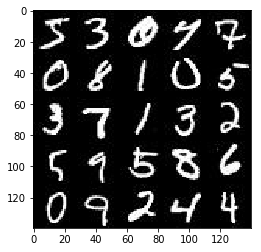

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

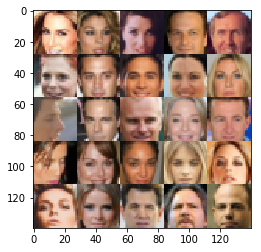

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(dtype=tf.float32, shape = [None, image_width, image_height, image_channels],name = 'input_images')
    z_data = tf.placeholder(dtype=tf.float32, shape = [None, z_dim],name = 'z_data')
    l_r = tf.placeholder(dtype = tf.float32, name = 'learning_rate')
    return input_images, z_data, l_r

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    with tf.variable_scope('discriminator',reuse=reuse):
        conv_1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        conv_1 = tf.maximum(alpha * conv_1, conv_1)
        
        conv_2 = tf.layers.conv2d(conv_1, 128, 5, strides=2, padding='same')
        conv_2 = tf.layers.batch_normalization(conv_2,  training=True)
        conv_2 = tf.maximum(alpha * conv_2, conv_2)
        
        conv_3 = tf.layers.conv2d(conv_2, 256, 5, strides=2, padding='same')
        conv_3 = tf.layers.batch_normalization(conv_3,  training=True)
        conv_3 = tf.maximum(alpha * conv_3, conv_3)

        flat  = tf.reshape(conv_3, (-1, 4*4*256))
        tensor_logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(tensor_logits)

    return output, tensor_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha*x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha*x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha*x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [23]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [24]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # i used https://github.com/husams/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb as a reference because i got stuck on this step A LOT
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 9.8955


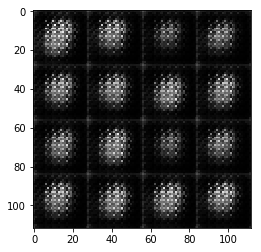

Epoch 1/2... Discriminator Loss: 2.2628... Generator Loss: 14.9761
Epoch 1/2... Discriminator Loss: 0.1517... Generator Loss: 2.7252


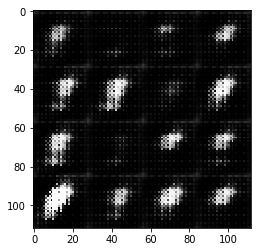

Epoch 1/2... Discriminator Loss: 0.7024... Generator Loss: 1.3082
Epoch 1/2... Discriminator Loss: 0.2094... Generator Loss: 4.2931


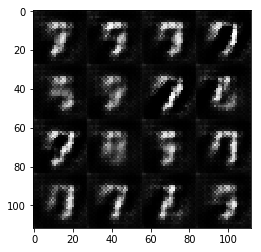

Epoch 1/2... Discriminator Loss: 0.2877... Generator Loss: 11.5180
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 0.8669


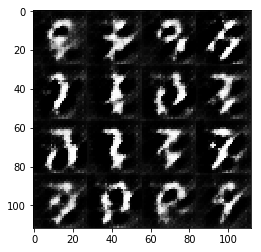

Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.2986
Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 2.5089


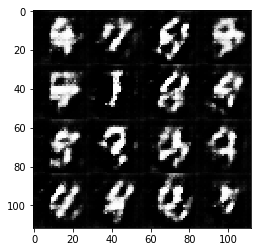

Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 3.2803
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.3738


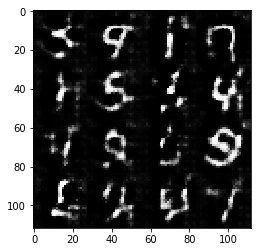

Epoch 1/2... Discriminator Loss: 1.4745... Generator Loss: 0.4203
Epoch 1/2... Discriminator Loss: 0.9731... Generator Loss: 0.8312


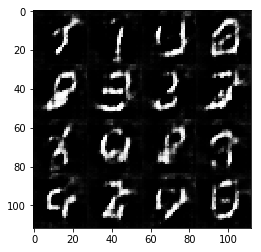

Epoch 1/2... Discriminator Loss: 0.7691... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 0.8626... Generator Loss: 0.9383


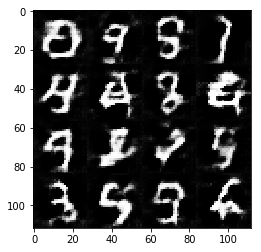

Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 1.1434
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.5137


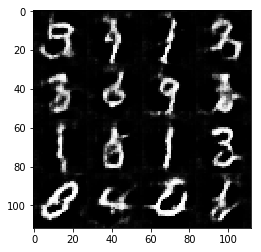

Epoch 1/2... Discriminator Loss: 0.7282... Generator Loss: 1.3261
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 2.3202


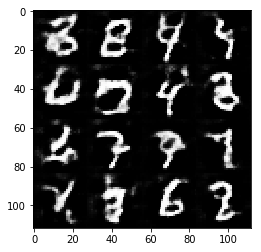

Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.0930
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.7789


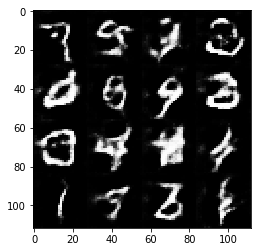

Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.8834


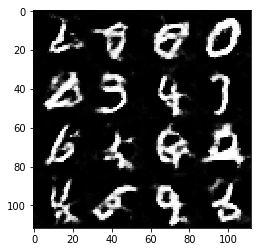

Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 0.8703... Generator Loss: 1.7066


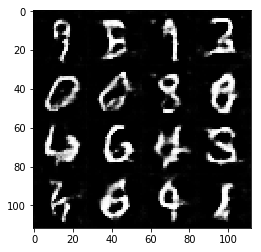

Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.4075
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 0.7345


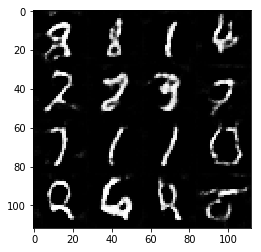

Epoch 1/2... Discriminator Loss: 1.6605... Generator Loss: 3.3228
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 2.2353


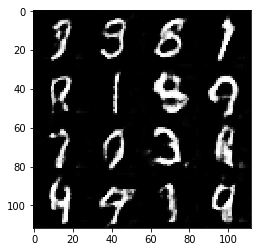

Epoch 1/2... Discriminator Loss: 1.1077... Generator Loss: 0.5995
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 0.9879


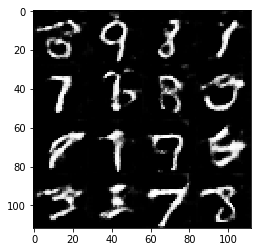

Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 1.1428


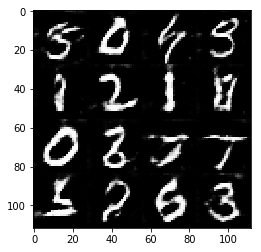

Epoch 1/2... Discriminator Loss: 0.6791... Generator Loss: 1.2268
Epoch 1/2... Discriminator Loss: 0.6865... Generator Loss: 1.5718


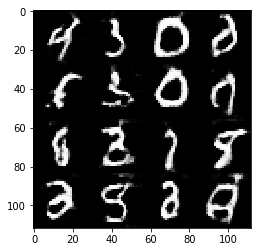

Epoch 1/2... Discriminator Loss: 0.7910... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 0.8272


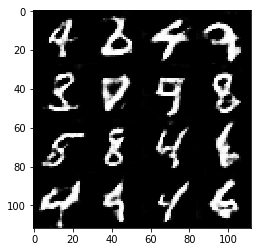

Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 0.8434... Generator Loss: 1.4152


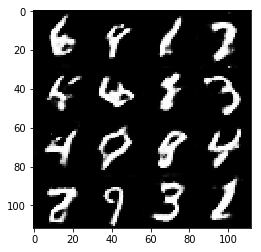

Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.4953
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.9686


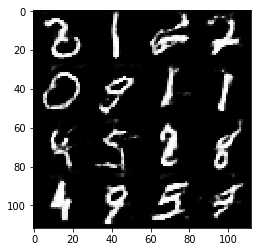

Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 0.7767
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.2509


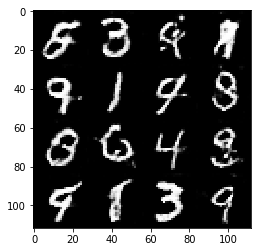

Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.7896
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 1.1323


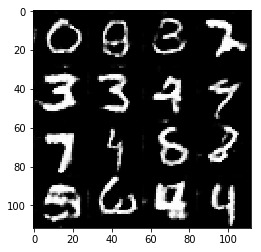

Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 0.7305... Generator Loss: 2.6007


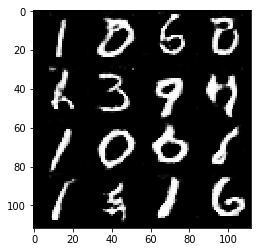

Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 0.9113
Epoch 2/2... Discriminator Loss: 0.8703... Generator Loss: 2.2669


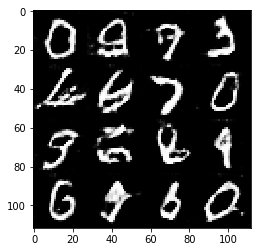

Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.2649
Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 0.5540


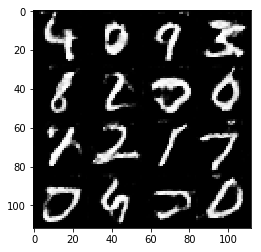

Epoch 2/2... Discriminator Loss: 1.0116... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.4886


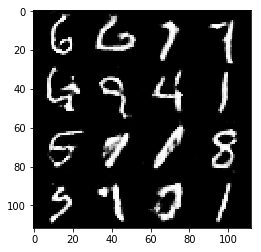

Epoch 2/2... Discriminator Loss: 1.5449... Generator Loss: 0.3239
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.4199


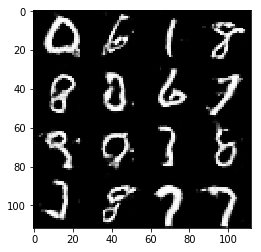

Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 1.6718
Epoch 2/2... Discriminator Loss: 0.7366... Generator Loss: 1.1594


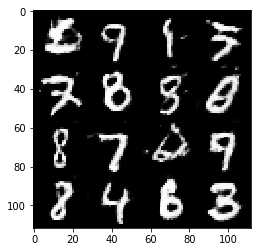

Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.2677
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.2983


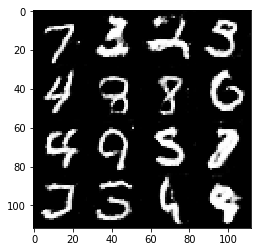

Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 0.7259
Epoch 2/2... Discriminator Loss: 0.6975... Generator Loss: 1.1469


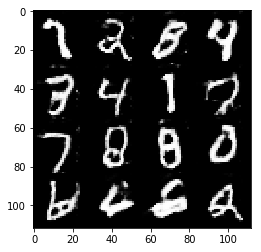

Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.0506
Epoch 2/2... Discriminator Loss: 1.0204... Generator Loss: 0.6420


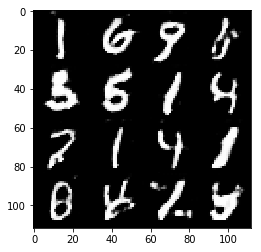

Epoch 2/2... Discriminator Loss: 0.7108... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.5104


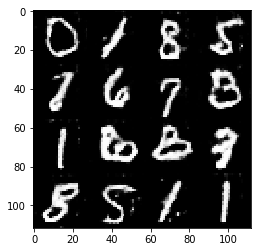

Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 2.1470
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 2.3849


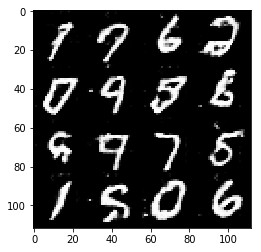

Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 0.6088
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 0.9231


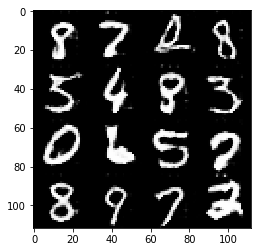

Epoch 2/2... Discriminator Loss: 1.8267... Generator Loss: 4.7310
Epoch 2/2... Discriminator Loss: 0.5781... Generator Loss: 1.5548


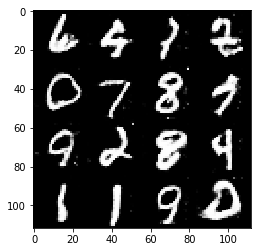

Epoch 2/2... Discriminator Loss: 0.9015... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.2309


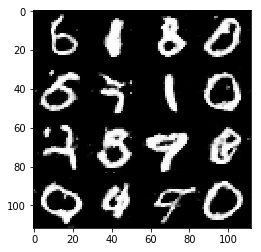

Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 0.9879


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 20.1406


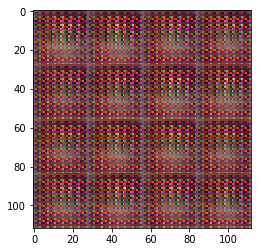

Epoch 1/1... Discriminator Loss: 0.0671... Generator Loss: 6.3457
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 6.6251


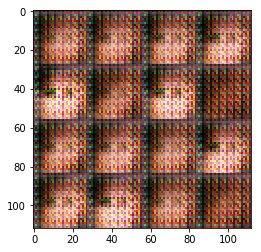

Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 2.0638
Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 4.8959


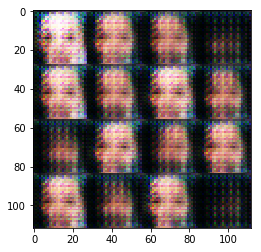

Epoch 1/1... Discriminator Loss: 0.3039... Generator Loss: 3.5076
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 4.8726


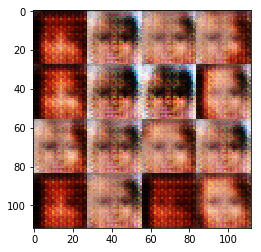

Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 2.4766


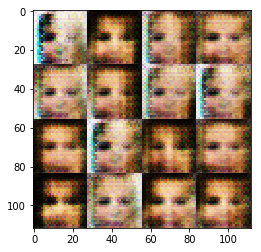

Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 2.9160


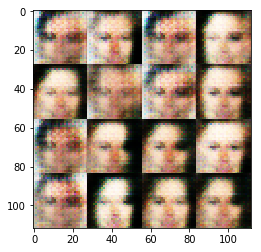

Epoch 1/1... Discriminator Loss: 0.7655... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 2.1401


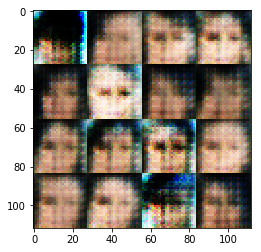

Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 4.9646
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.7468


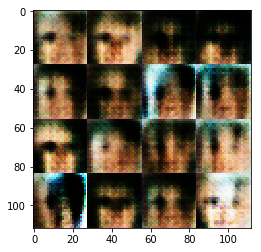

Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 2.0201
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7071


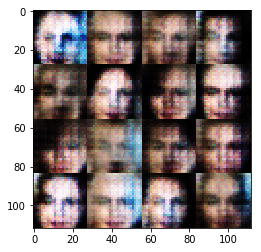

Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.6109... Generator Loss: 1.2991


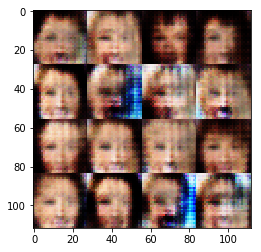

Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.3158


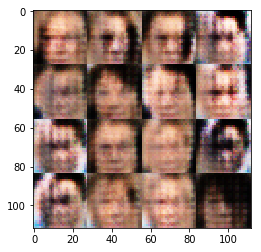

Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 0.6513... Generator Loss: 1.1893


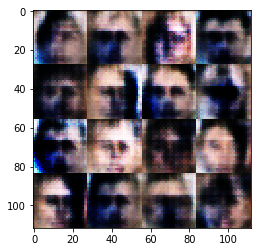

Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 1.9647
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.4908


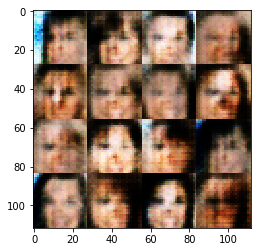

Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.9936
Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 2.1197


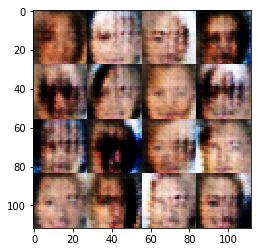

Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.5214
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.6323


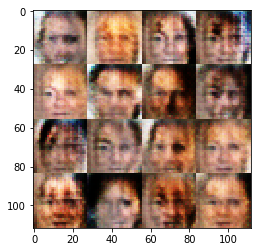

Epoch 1/1... Discriminator Loss: 0.5905... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.6292... Generator Loss: 1.5781


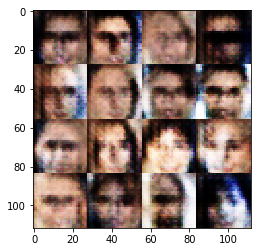

Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.2983
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 3.4145


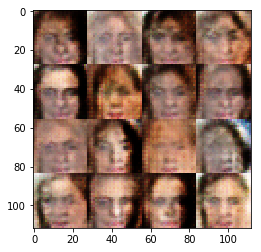

Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 2.7333
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 0.8224


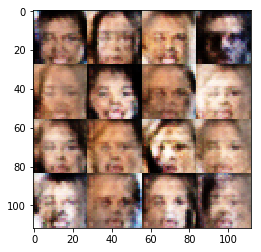

Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 1.9630


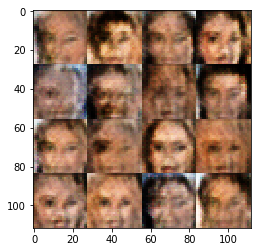

Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.8444
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.6389


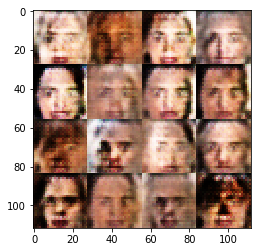

Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.3767
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.5958


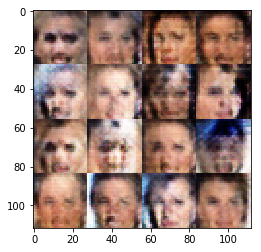

Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.5547


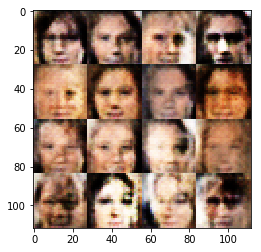

Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 0.7975... Generator Loss: 1.4619


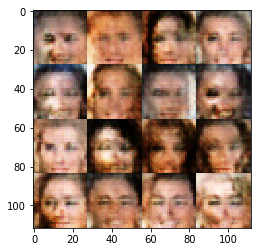

Epoch 1/1... Discriminator Loss: 0.9334... Generator Loss: 2.8281
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 0.9075


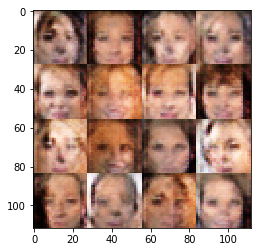

Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.1863


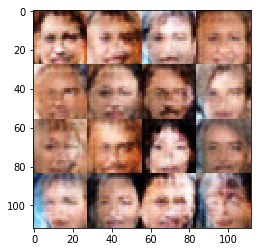

Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 2.0368
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.3760


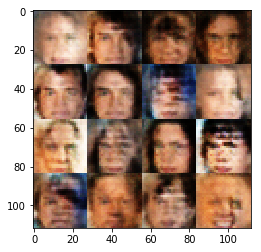

Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 2.4770
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 3.6647


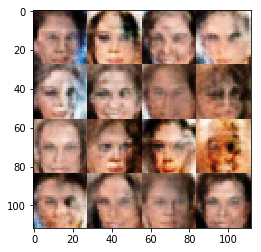

Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 2.0319


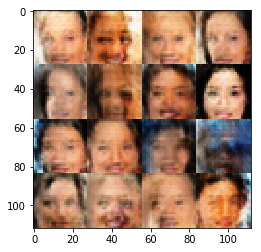

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.4427


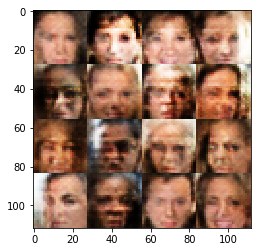

Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.5857


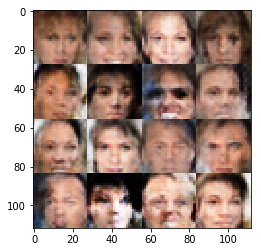

Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 2.6564


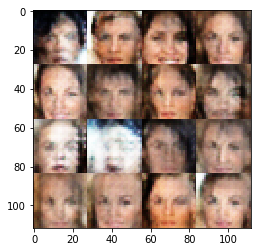

Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 2.3617


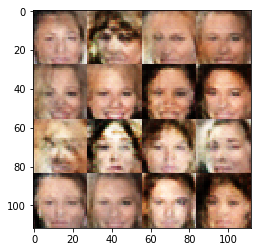

Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6659


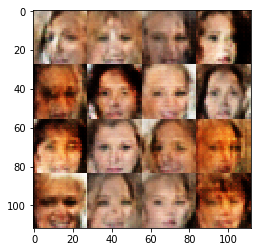

Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.5650


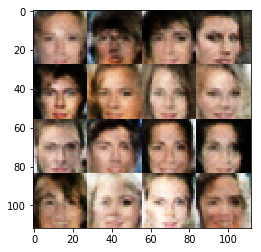

Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.5903


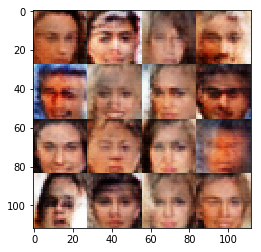

Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.0847
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.3325


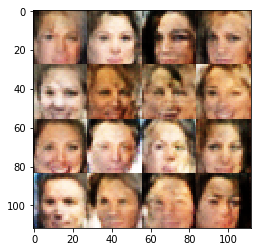

Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.3446


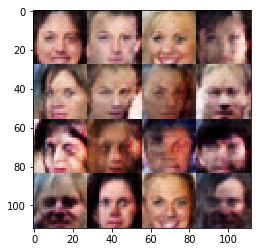

Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.7282


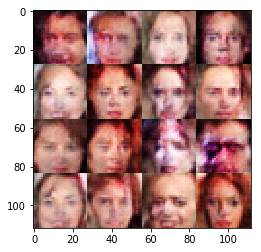

Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.4665
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.3299


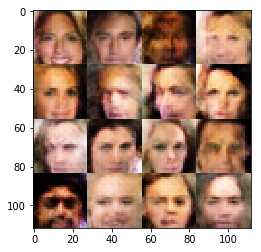

Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 2.3114
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.4038


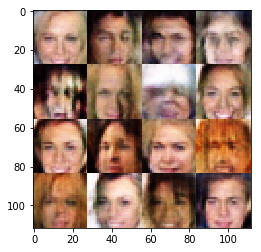

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.6960


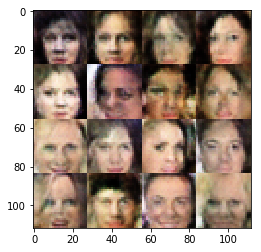

Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 2.0154
Epoch 1/1... Discriminator Loss: 0.8509... Generator Loss: 2.1719


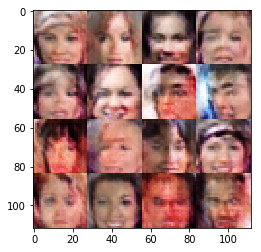

Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.1307


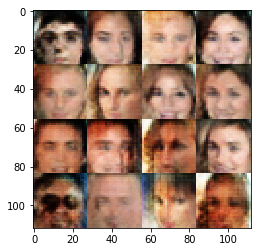

Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.4065


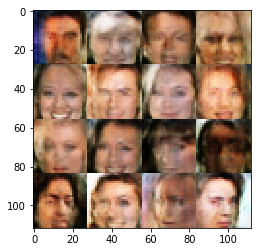

Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.4981


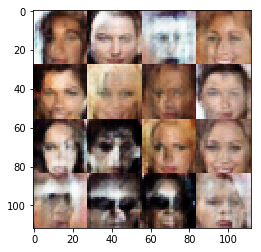

Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.8732
Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.2823


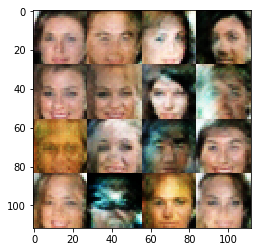

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 2.1548
Epoch 1/1... Discriminator Loss: 0.9752... Generator Loss: 1.1415


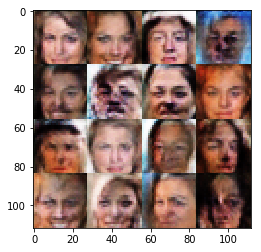

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.4384


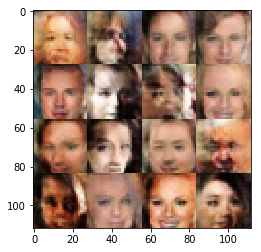

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.6181


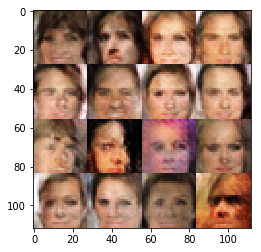

Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 1.0015


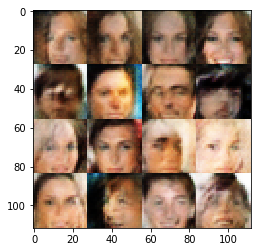

Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.9167


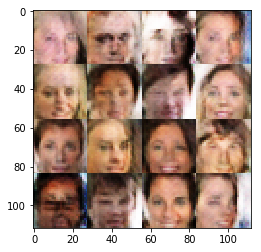

Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.6071


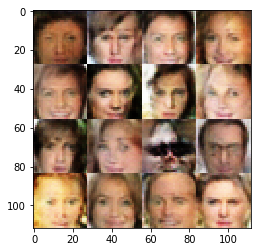

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6088


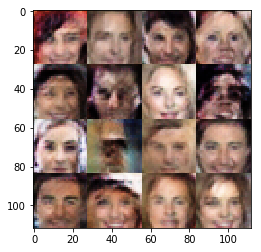

Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.6643


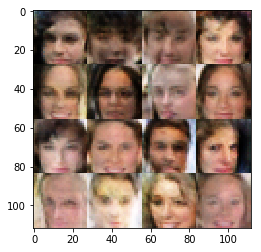

Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.0357


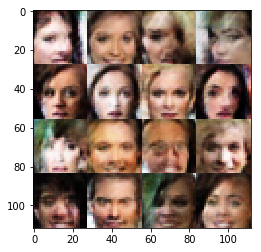

Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 1.8005


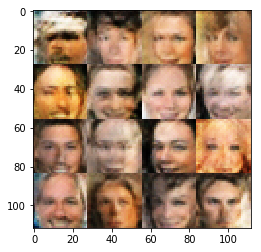

Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.6727


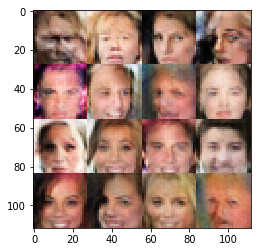

Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.8344


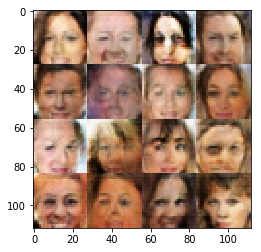

Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.2970
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.8478


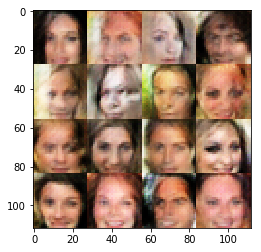

Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 0.9677... Generator Loss: 0.7748


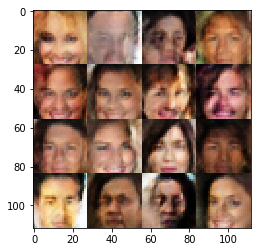

Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.5037


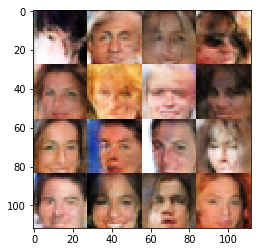

Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5938


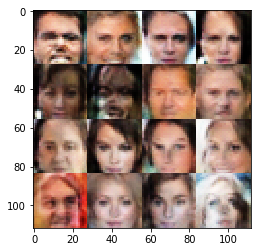

Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.4966


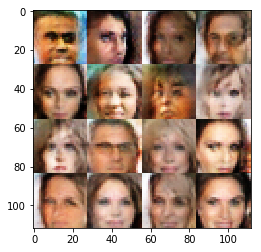

Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 1.6485


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.